In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import time
import psutil
from collections import defaultdict


In [70]:
# Dataset generation
def generate_dataset(N, D=2):
    return np.random.rand(N, D)


In [71]:
# Naive KNN
def naive_knn(X_train, query, k):
    distances = np.sqrt(((X_train - query) ** 2).sum(axis=1))
    nearest_neighbors = np.argsort(distances)[:k]
    return nearest_neighbors


In [72]:
def kd_tree_knn(X_train, query, k):
    query = np.array(query).reshape(1, -1)  # Reshape to (1, D)
    tree = KDTree(X_train)
    distances, indices = tree.query(query, k=k)
    return indices[0]


In [73]:
class LSH:
    def __init__(self, num_hash_tables, hash_size, input_dim, max_candidates=50):
        """
        Initialize LSH for approximate nearest neighbor search.
        :param num_hash_tables: Number of hash tables.
        :param hash_size: Number of random projections per hash table.
        :param input_dim: Dimensionality of the input data.
        :param max_candidates: Maximum number of candidates to consider for approximation.
        """
        self.num_hash_tables = num_hash_tables
        self.hash_size = hash_size
        self.input_dim = input_dim
        self.max_candidates = max_candidates
        self.hash_tables = [defaultdict(list) for _ in range(num_hash_tables)]
        self.projections = [np.random.randn(hash_size, input_dim) for _ in range(num_hash_tables)]

    def _hash_function(self, data, projections):
        """
        Hash function that maps data to binary hash codes.
        :param data: Input data (N, D).
        :param projections: Random projection matrix (hash_size, input_dim).
        :return: Tuple hash code for the data.
        """
        hash_code = (np.dot(data, projections.T) > 0).astype(int)
        return tuple(hash_code.flatten())  # Convert to a tuple for hashability

    def fit(self, data):
        """
        Index data points into hash tables.
        :param data: Input data to index (N, D).
        """
        self.data = data
        for idx, point in enumerate(data):
            for table, proj in zip(self.hash_tables, self.projections):
                hash_code = self._hash_function(point.reshape(1, -1), proj)
                table[hash_code].append(idx)

    def query(self, query_point, k):
        """
        Query the hash tables for approximate nearest neighbors.
        :param query_point: Query data point (1, D).
        :param k: Number of neighbors to retrieve.
        :return: Indices of approximate neighbors.
        """
        candidate_indices = set()
        for table, proj in zip(self.hash_tables, self.projections):
            hash_code = self._hash_function(query_point.reshape(1, -1), proj)
            candidate_indices.update(table.get(hash_code, []))
        
        # Limit candidates to enforce approximation
        if len(candidate_indices) > self.max_candidates:
            candidate_indices = np.random.choice(list(candidate_indices), self.max_candidates, replace=False)

        # Rank candidates by actual distance
        candidates = np.array(list(candidate_indices))
        distances = euclidean_distances(query_point.reshape(1, -1), self.data[candidates]).flatten()
        sorted_indices = np.argsort(distances)
        return candidates[sorted_indices[:k]]


In [74]:
def benchmark_knn(X_train, query, k, knn_func):
    # Ensure query is 2D
    query = np.array(query).reshape(1, -1)
    
    start_time = time.time()
    mem_before = psutil.Process().memory_info().rss
    neighbors = knn_func(X_train, query, k)
    mem_after = psutil.Process().memory_info().rss
    end_time = time.time()
    
    time_taken = end_time - start_time
    memory_used = mem_after - mem_before
    return neighbors, time_taken, memory_used


In [75]:
# Plotting missed neighbors
def plot_missed_neighbors(X, query, neighbors_exact, neighbors_approx, title):
    plt.scatter(X[:, 0], X[:, 1],color="blue", label="Data points", alpha=0.6)
    plt.scatter(query[0], query[1], color="red", label="Query point")
    
    # Exact neighbors
    plt.scatter(X[neighbors_exact][:, 0], X[neighbors_exact][:, 1], color="orange", label="Naive Neighbors")
    
    # Approximate neighbors
    plt.scatter(X[neighbors_approx][:, 0], X[neighbors_approx][:, 1], color="black", label="Func def Neighbors", marker="x")
    
    # Missed neighbors
    missed = set(neighbors_exact) - set(neighbors_approx)
    if missed:
        missed_indices = list(missed)
        plt.scatter(X[missed_indices][:, 0], X[missed_indices][:, 1], color="yellow", label="Missed Neighbors", marker="*")
    
    plt.legend()
    plt.title(title)
    plt.show()

In [76]:
import numpy as np
import matplotlib.pyplot as plt

class CustomKDTree:
    """
    A simple KD-Tree implementation for 2D data, suitable for visualization.
    """
    def __init__(self, data, depth=0):
        self.axis = depth % 2
        self.median_idx = None
        self.split_val = None
        self.left = None
        self.right = None
        
        if len(data) > 0:
            data = data[data[:, self.axis].argsort()]
            median_idx = len(data) // 2
            self.split_val = data[median_idx, self.axis]
            self.median_idx = median_idx
            
            self.left = CustomKDTree(data[:median_idx], depth + 1)
            self.right = CustomKDTree(data[median_idx + 1:], depth + 1)

def plot_kdtree_partitions(tree, X, query_point, ax=None, limits=None, depth=0):
    """
    Plot KD-Tree partitions recursively.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    query_point = np.array(query_point).flatten()
    
    # Plot dataset and query point
    ax.scatter(X[:, 0], X[:, 1], s=20, c="blue", label="Data Points")
    ax.scatter(query_point[0], query_point[1], c="red", s=100, label="Query Point")

    # Initialize limits for the first call
    if limits is None:
        limits = [[np.min(X[:, 0]), np.max(X[:, 0])], [np.min(X[:, 1]), np.max(X[:, 1])]]

    # Recursive plotting
    def plot_recursive(node, current_limits, current_depth):
        if node is None or node.split_val is None:
            return

        axis = current_depth % 2
        if axis == 0:  # Vertical split
            ax.plot([node.split_val, node.split_val], current_limits[1], 'g--', alpha=0.5)
            left_limits = [[current_limits[0][0], node.split_val], current_limits[1]]
            right_limits = [[node.split_val, current_limits[0][1]], current_limits[1]]
        else:  # Horizontal split
            ax.plot(current_limits[0], [node.split_val, node.split_val], 'g--', alpha=0.5)
            left_limits = [current_limits[0], [current_limits[1][0], node.split_val]]
            right_limits = [current_limits[0], [node.split_val, current_limits[1][1]]]

        # Recursively plot child nodes
        plot_recursive(node.left, left_limits, current_depth + 1)
        plot_recursive(node.right, right_limits, current_depth + 1)

    plot_recursive(tree, limits, depth)
    
    ax.legend()
    ax.set_title("KD-Tree Partitions in 2D Space")
    plt.show()


# Example usage
# X_2d = np.random.rand(100, 2)  # Generate a random 2D dataset
# query_point = [0.5, 0.5]  # Example query point



In [78]:
def plot_lsh_partitions(lsh, X, query_point):
    fig, ax = plt.subplots(figsize=(8, 8))
    # query_point = np.array(query_point).reshape(1, -1) 
    query_point = np.array(query_point).flatten()
    
    # X = np.reshape(X, (2,500)) 
    a,b = X.shape
    X = np.reshape(X, (a,b))
    
    # Plot dataset
    ax.scatter(X[:, 0], X[:, 1], s=20, c="blue", label="Data Points")
    ax.scatter(query_point[0], query_point[1], c="red", s=100, label="Query Point")
    
    # Plot hash function hyperplanes
    for proj in lsh.projections:
        # Each hyperplane is determined by the normal vector (projection)
        x_vals = np.linspace(0, 1, 100)
        for i in range(lsh.hash_size):
            slope = -proj[i, 0] / proj[i, 1] if proj[i, 1] != 0 else 0
            intercept = 0
            y_vals = slope * x_vals + intercept
            ax.plot(x_vals, y_vals, '-', alpha=0.5) #, label=f'Hash Hyperplane {i+1}')
    
    
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    
    ax.legend()
    ax.set_title("LSH Partitions in 2D Space")
    plt.show()

# Create LSH instance and fit data
# lsh = LSH(num_hash_tables=5, hash_size=2, input_dim=2)
# lsh.fit(X_2d)


Naive KNN: Time = 0.000000 s, Memory = 12.00 KB
KD-Tree: Time = 0.001017 s, Memory = 8.00 KB
LSH: Time = 0.002003 s, Memory = 8.00 KB


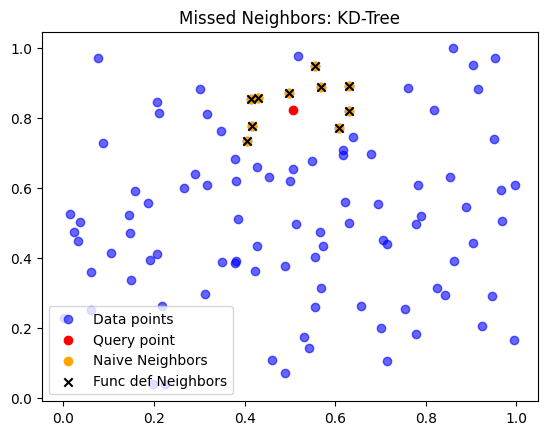

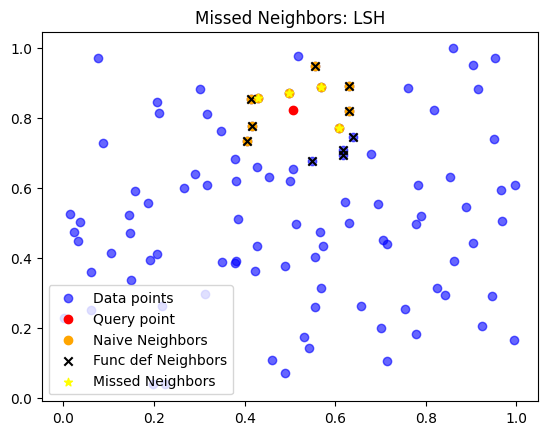

In [95]:
# Main function
# Dataset parameters
N = 100
D = 2
k = 10

# Generate 2D dataset
X_2d = generate_dataset(N, D)
query_point = np.random.rand(1, D)

# Initialize LSH
num_hash_tables = 5 #5
hash_size = 4  #4
lsh = LSH(num_hash_tables, hash_size, input_dim=D)
lsh.fit(X_2d)

# Compare KNN methods
neighbors_naive, time_naive, memory_naive = benchmark_knn(X_2d, query_point, k, naive_knn)
neighbors_kdtree, time_kdtree, memory_kdtree = benchmark_knn(X_2d, query_point, k, kd_tree_knn)
neighbors_lsh, time_lsh, memory_lsh = benchmark_knn(X_2d, query_point, k, lambda X, q, k: lsh.query(q, k))

# Print benchmarking results
print(f"Naive KNN: Time = {time_naive:.6f} s, Memory = {memory_naive / 1024:.2f} KB")
print(f"KD-Tree: Time = {time_kdtree:.6f} s, Memory = {memory_kdtree / 1024:.2f} KB")
print(f"LSH: Time = {time_lsh:.6f} s, Memory = {memory_lsh / 1024:.2f} KB")

# Visualize missed neighbors
plot_missed_neighbors(X_2d, query_point.flatten(), neighbors_naive, neighbors_kdtree, "Missed Neighbors: KD-Tree")
plot_missed_neighbors(X_2d, query_point.flatten(), neighbors_naive, neighbors_lsh, "Missed Neighbors: LSH")

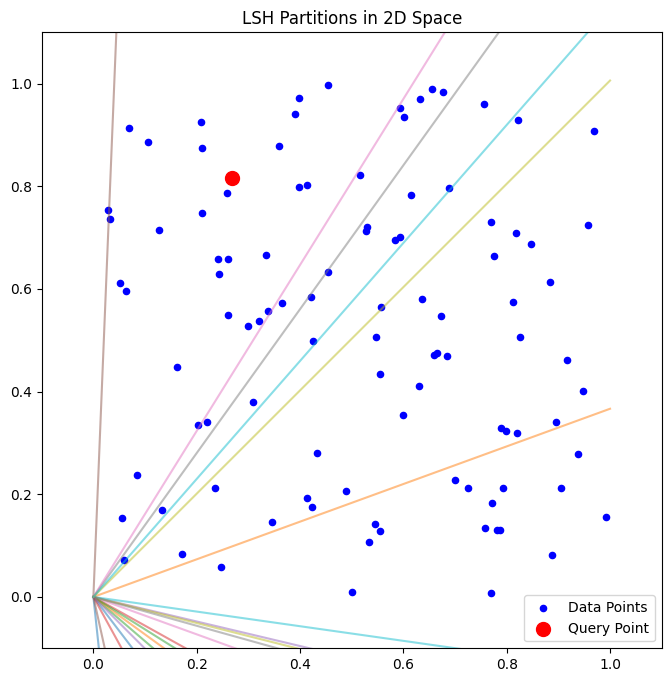

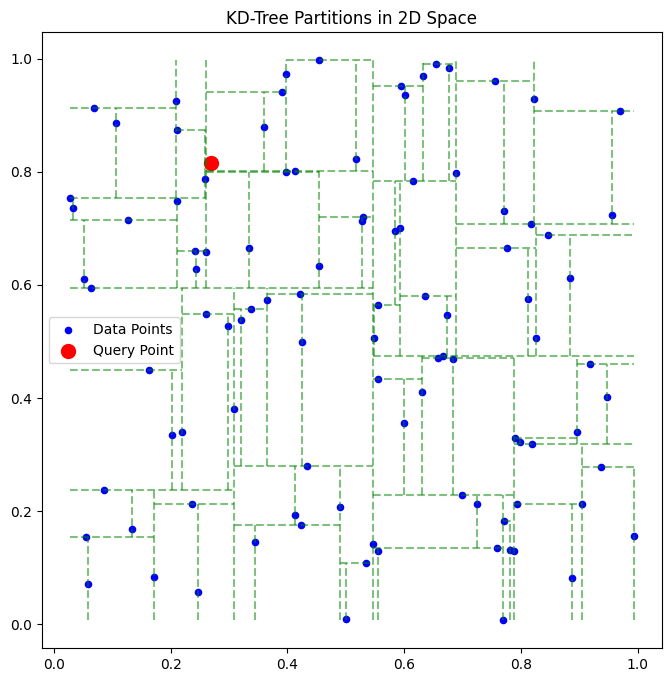

In [83]:

# Plot partitions
plot_lsh_partitions(lsh, X_2d, query_point)

# Build the custom KD-Tree
custom_kd_tree = CustomKDTree(X_2d)
# Plot partitions
plot_kdtree_partitions(custom_kd_tree, X_2d, query_point)


In [165]:
N = 100
D = 2
k = 10

# Generate 2D dataset
X_2d = generate_dataset(N, D)
query_point = np.random.rand(1, D)

# Initialize LSH
num_hash_tables = 5 #5
hash_size = 4  #4
lsh = LSH(num_hash_tables, hash_size, input_dim=D)
lsh.fit(X_2d)

# Compare KNN methods
neighbors_naive, time_naive, memory_naive = benchmark_knn(X_2d, query_point, k, naive_knn)
neighbors_kdtree, time_kdtree, memory_kdtree = benchmark_knn(X_2d, query_point, k, kd_tree_knn)
neighbors_lsh, time_lsh, memory_lsh = benchmark_knn(X_2d, query_point, k, lambda X, q, k: lsh.query(q, k))

# Print benchmarking results
print(f"Naive KNN: Time = {time_naive:.8f} s, Memory = {memory_naive/1024 :.8f} KB")
print(f"KD-Tree: Time = {time_kdtree:.8f} s, Memory = {memory_kdtree / 1024:.8f} KB")
print(f"LSH: Time = {time_lsh:.8f} s, Memory = {memory_lsh / 1024:.8f} KB")
print(query_point)

Naive KNN: Time = 0.00000000 s, Memory = 4.00000000 KB
KD-Tree: Time = 0.00155687 s, Memory = 0.00000000 KB
LSH: Time = 0.00202060 s, Memory = 8.00000000 KB
[[0.53547219 0.55663285]]


In [202]:
avg_time = []
avg_mem = []

N = 100
for D in  [2,3,4,5,6]:
    for k in [2,10,50]:
        X_2d = generate_dataset(N, D)
        
        num_hash_tables = 5 #5
        hash_size = 4  #4
        lsh = LSH(num_hash_tables, hash_size, input_dim=D)
        lsh.fit(X_2d)
        
        sum_time = 0
        sum_mem = 0
        i = 0
        while i < 4:
            query_point = np.random.rand(1, D)
            neighbors_naive, time_naive, memory_naive = benchmark_knn(X_2d, query_point, k, kd_tree_knn)
            
            if memory_naive != 0 :
                # print(f"Naive KNN: Time = {time_naive:.8f} s, Memory = {memory_naive/1024 :.8f} KB")
                sum_time = sum_time + time_naive 
                sum_mem = sum_mem + memory_naive
                i = i+1 
                print(i, N, D, k, memory_naive, time_naive)
            else :
                pass
            
            # print(i, memory_naive, time_naive)
                
            
        avg_time.append(sum_time/4) 
        avg_mem.append(sum_mem/4) 
        
        print(f"Naive KNN: Time = {sum_time/4:.8f} s, Memory = {sum_mem/4096 :.8f} KB, k = {float(k)}, D = {float(D)}, N = {float(N)}")

1 100 2 2 8192 0.0011665821075439453
2 100 2 2 8192 0.0010001659393310547
3 100 2 2 4096 0.0009987354278564453
4 100 2 2 4096 0.0
Naive KNN: Time = 0.00079137 s, Memory = 6.00000000 KB, k = 2.0, D = 2.0, N = 100.0
1 100 2 10 -118784 0.0
2 100 2 10 12288 0.0010845661163330078
3 100 2 10 4096 0.0
4 100 2 10 4096 0.0
Naive KNN: Time = 0.00027114 s, Memory = -24.00000000 KB, k = 10.0, D = 2.0, N = 100.0
1 100 2 50 4096 0.0
2 100 2 50 4096 0.0
3 100 2 50 4096 0.0009996891021728516
4 100 2 50 4096 0.0
Naive KNN: Time = 0.00024992 s, Memory = 4.00000000 KB, k = 50.0, D = 2.0, N = 100.0
1 100 3 2 -16384 0.0010001659393310547
2 100 3 2 4096 0.0010042190551757812
3 100 3 2 4096 0.0
4 100 3 2 -8192 0.0010001659393310547
Naive KNN: Time = 0.00075114 s, Memory = -4.00000000 KB, k = 2.0, D = 3.0, N = 100.0
1 100 3 10 4096 0.0
2 100 3 10 4096 0.0
3 100 3 10 -8192 0.0013415813446044922
4 100 3 10 4096 0.0
Naive KNN: Time = 0.00033540 s, Memory = 1.00000000 KB, k = 10.0, D = 3.0, N = 100.0
1 100 3 50 4

In [203]:
print(avg_mem)

[6144.0, -24576.0, 4096.0, -4096.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 8192.0, -5120.0, 7168.0, -14336.0, 1024.0, 2048.0]


D = 2 , k = 2, 10, 50 , N 100, 300, 500, 700, 900. 
naive_time
[0.000999748706817627, 0.0009992718696594238, 0.0011748075485229492, 0.0009748935699462891, 0.001002490520477295, 0.0009999871253967285, 0.0011706948280334473, 0.00099945068359375, 0.0009992122650146484, 0.0009999871253967285, 0.0010336041450500488, 0.0009999871253967285, 0.0009999871253967285, 0.0010012388229370117, 0.0010930895805358887]

naive_memory
[7168.0, 5120.0, 19456.0, 24576.0, 40960.0, 4096.0, 3072.0, 20480.0, 25600.0, 12288.0, 8192.0, 3072.0, 19456.0, 3072.0, 28672.0] 

lsh_time
[0.0011855363845825195, 0.001081705093383789, 0.001003563404083252, 0.0009992718696594238, 0.0009996294975280762, 0.0009995698928833008, 0.0009998679161071777, 0.0010072588920593262, 0.0010004639625549316, 0.0009995102882385254, 0.0009998679161071777, 0.0010584592819213867, 0.0010001063346862793, 0.0010045766830444336, 0.0009996891021728516]

lsh_memory
[19456.0, 7168.0, 11264.0, 16384.0, -83968.0, 5120.0, 7168.0, 27648.0, 41984.0, 12288.0, 5120.0, 5120.0, 5120.0, 5120.0, 21504.0]

kdtree_time
[0.0010027289390563965, 0.0010005831718444824, 0.0010001659393310547, 0.00099945068359375, 0.0010007023811340332, 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793, 0.0010026097297668457, 0.0009999871253967285, 0.0009999275207519531, 0.001000046730041504, 0.0010687708854675293] 

kdtree_mem
[1024.0, 4096.0, 16384.0, 16384.0, 6144.0, 4096.0, 8192.0, 15360.0, 16384.0, 25600.0, 4096.0, 38912.0, 14336.0, 16384.0, 55296.0]


D = 2,3,4,5,6 , k = 2, 10, 50 , N 100. 

naive_time
[0.0009573698043823242, 0.0011494159698486328, 0.000999748706817627, 0.0009998679161071777, 0.0010745525360107422, 0.0009999275207519531, 0.0010228753089904785, 0.0010653138160705566, 0.0011092424392700195, 0.0010586977005004883, 0.0010007619857788086, 0.001002490520477295, 0.0010119080543518066, 0.0010025501251220703, 0.0009999871253967285]
naive_mem
[5120.0, 9216.0, 3072.0, 8192.0, 3072.0, 2048.0, 2048.0, 2048.0, 6144.0, 3072.0, 8192.0, 13312.0, 13312.0, 6144.0, 1024.0] 

lsh_time
[0.0010661482810974121, 0.0011864900588989258, 0.0009996891021728516, 0.0010004043579101562, 0.001000523567199707, 0.0009998679161071777, 0.0011278390884399414, 0.0010006427764892578, 0.0010024309158325195, 0.000998854637145996, 0.00100022554397583, 0.001064896583557129, 0.0010014772415161133, 0.0010004043579101562, 0.001127004623413086]
lsh_mem
[12288.0, 5120.0, 4096.0, 4096.0, 5120.0, 4096.0, 6144.0, 4096.0, 4096.0, 5120.0, 64512.0, 6144.0, 4096.0, 4096.0, 4096.0]


kdtree_time
[0.0010167956352233887, 0.0010003447532653809, 0.0010027885437011719, 0.0011621713638305664, 0.0010002851486206055, 0.0010006427764892578, 0.0010273456573486328, 0.001004040241241455, 0.00110703706741333, 0.0010004043579101562, 0.001000523567199707, 0.0010006427764892578, 0.0010004043579101562, 0.0010006427764892578, 0.0010027289390563965]
kdtree_mem
[6144.0, 24576.0, 4096.0, 4096.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 8192.0, 5120.0, 7168.0, 14336.0, 1024.0, 2048.0]

time :
k = 2
N = N 100, 300, 500, 700, 900

naive_time = [0.000999748706817627, 0.0009992718696594238, 0.0011748075485229492, 0.0009748935699462891, 0.001002490520477295]
lsh_time = [0.0011855363845825195, 0.001081705093383789, 0.001003563404083252, 0.0009992718696594238, 0.0009996294975280762]
kdtree_time = [0.0010027289390563965, 0.0010005831718444824, 0.0010001659393310547, 0.00099945068359375, 0.0010007023811340332]

k = 10
N = N 100, 300, 500, 700, 900

naive_time = [0.0009999871253967285, 0.0011706948280334473, 0.00099945068359375, 0.0009992122650146484, 0.0009999871253967285]
lsh_time = [0.0009995698928833008, 0.0009998679161071777, 0.0010072588920593262, 0.0010004639625549316, 0.0009995102882385254]
kdtree_time = [ 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793]


k = 50
N = N 100, 300, 500, 700, 900

naive_time = [0.0010336041450500488, 0.0009999871253967285, 0.0009999871253967285, 0.0010012388229370117, 0.0010930895805358887]
lsh_time = [0.0009998679161071777, 0.0010584592819213867, 0.0010001063346862793, 0.0010045766830444336, 0.0009996891021728516]
kdtree_time = [ 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793]


mem :
k = 2
N = N 100, 300, 500, 700, 900

naive_mem = [7168.0, 5120.0, 19456.0, 24576.0, 40960.0] 
lsh_mem = [19456.0, 7168.0, 11264.0, 16384.0, 83968.0]
kdtree_mem = [6144.0, 24576.0, 4096.0, 4096.0, 1024.0]

k = 10
N = N 100, 300, 500, 700, 900

naive_mem =  [4096.0, 3072.0, 20480.0, 25600.0, 12288.0]
lsh_mem = [5120.0, 7168.0, 27648.0, 41984.0, 12288.0]
kdtree_mem = [1024.0, 1024.0, 1024.0, 1024.0, 8192.0]


k = 50
N = N 100, 300, 500, 700, 900

naive_mem = [8192.0, 3072.0, 19456.0, 3072.0, 28672.0]
lsh_mem = [5120.0, 5120.0, 5120.0, 5120.0, 21504.0]
kdtree_mem = [5120.0, 7168.0, 14336.0, 1024.0, 2048.0]

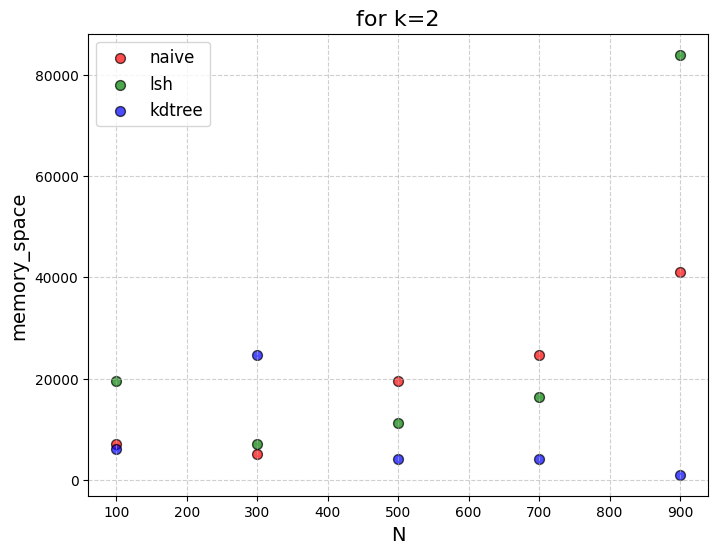

In [211]:
# mem :
k = 2
N = [100, 300, 500, 700, 900]

naive_mem = [7168.0, 5120.0, 19456.0, 24576.0, 40960.0] 
lsh_mem = [19456.0, 7168.0, 11264.0, 16384.0, 83968.0]
kdtree_mem = [6144.0, 24576.0, 4096.0, 4096.0, 1024.0]


plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_mem, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_mem, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_mem, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=2", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("memory_space", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

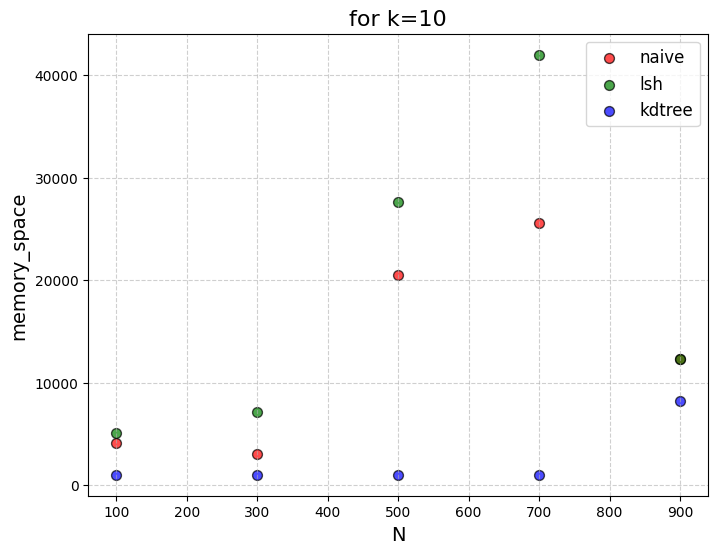

In [213]:
# mem :
k = 10
N = [100, 300, 500, 700, 900]

naive_mem =  [4096.0, 3072.0, 20480.0, 25600.0, 12288.0]
lsh_mem = [5120.0, 7168.0, 27648.0, 41984.0, 12288.0]
kdtree_mem = [1024.0, 1024.0, 1024.0, 1024.0, 8192.0]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_mem, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_mem, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_mem, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=10", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("memory_space", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

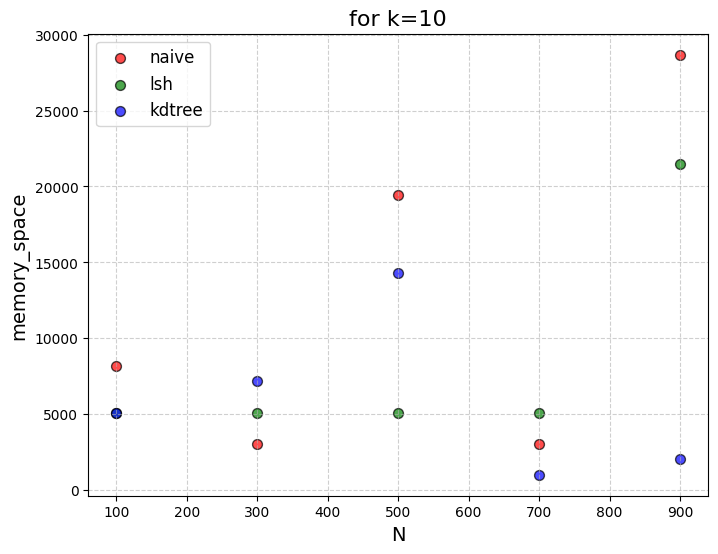

In [214]:
# mem :
k = 50
N = [100, 300, 500, 700, 900]

naive_mem = [8192.0, 3072.0, 19456.0, 3072.0, 28672.0]
lsh_mem = [5120.0, 5120.0, 5120.0, 5120.0, 21504.0]
kdtree_mem = [5120.0, 7168.0, 14336.0, 1024.0, 2048.0]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_mem, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_mem, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_mem, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=10", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("memory_space", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

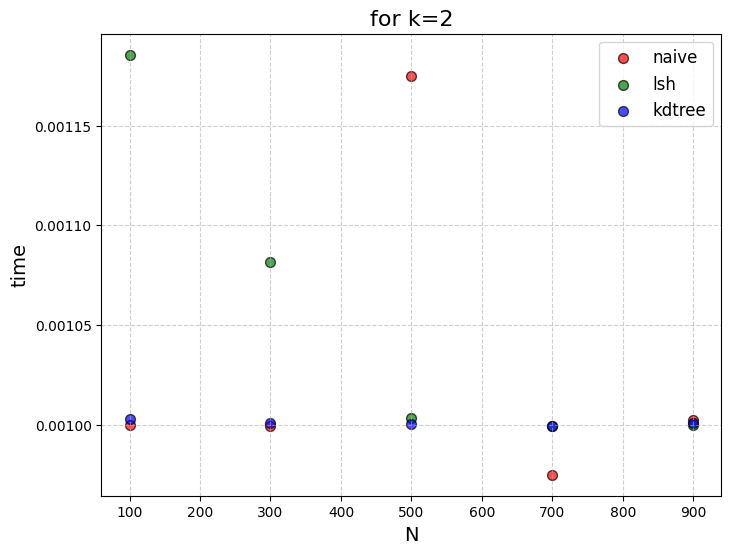

In [216]:
# mem :
k = 2
N = [100, 300, 500, 700, 900]

naive_time = [0.000999748706817627, 0.0009992718696594238, 0.0011748075485229492, 0.0009748935699462891, 0.001002490520477295]
lsh_time = [0.0011855363845825195, 0.001081705093383789, 0.001003563404083252, 0.0009992718696594238, 0.0009996294975280762]
kdtree_time = [0.0010027289390563965, 0.0010005831718444824, 0.0010001659393310547, 0.00099945068359375, 0.0010007023811340332]



plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_time, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_time, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_time, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=2", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("time", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

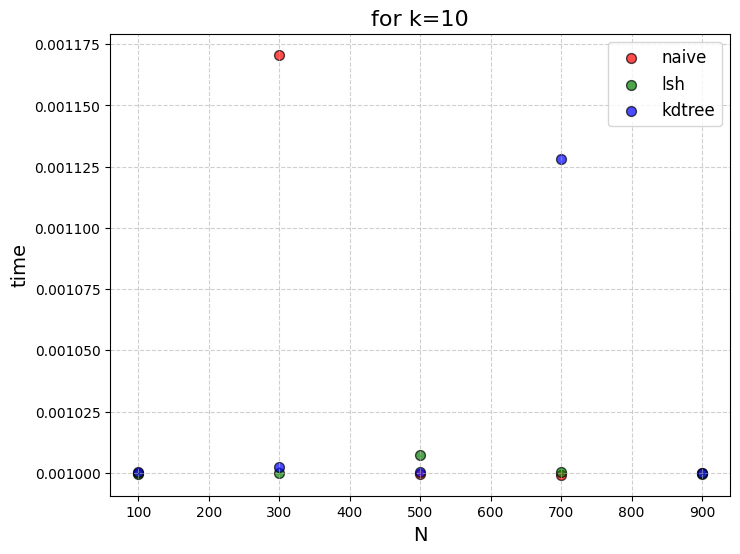

In [217]:
# mem :
k = 10
N = [100, 300, 500, 700, 900]

naive_time = [0.0009999871253967285, 0.0011706948280334473, 0.00099945068359375, 0.0009992122650146484, 0.0009999871253967285]
lsh_time = [0.0009995698928833008, 0.0009998679161071777, 0.0010072588920593262, 0.0010004639625549316, 0.0009995102882385254]
kdtree_time = [ 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_time, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_time, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_time, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=10", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("time", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

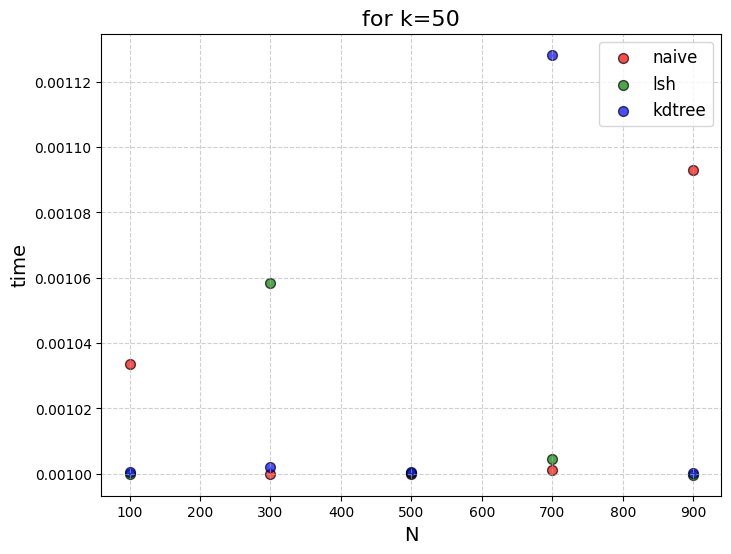

In [219]:
# mem :
k = 50
N = [100, 300, 500, 700, 900]

naive_time = [0.0010336041450500488, 0.0009999871253967285, 0.0009999871253967285, 0.0010012388229370117, 0.0010930895805358887]
lsh_time = [0.0009998679161071777, 0.0010584592819213867, 0.0010001063346862793, 0.0010045766830444336, 0.0009996891021728516]
kdtree_time = [ 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_time, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_time, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_time, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=50", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("time", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

naive_time
[0.0009573698043823242, 0.0011494159698486328, 0.000999748706817627, 0.0009998679161071777, 0.0010745525360107422, 0.0009999275207519531, 0.0010228753089904785, 0.0010653138160705566, 0.0011092424392700195, 0.0010586977005004883, 0.0010007619857788086, 0.001002490520477295, 0.0010119080543518066, 0.0010025501251220703, 0.0009999871253967285]
naive_mem
[5120.0, 9216.0, 3072.0, 8192.0, 3072.0, 2048.0, 2048.0, 2048.0, 6144.0, 3072.0, 8192.0, 13312.0, 13312.0, 6144.0, 1024.0] 

lsh_time
[0.0010661482810974121, 0.0011864900588989258, 0.0009996891021728516, 0.0010004043579101562, 0.001000523567199707, 0.0009998679161071777, 0.0011278390884399414, 0.0010006427764892578, 0.0010024309158325195, 0.000998854637145996, 0.00100022554397583, 0.001064896583557129, 0.0010014772415161133, , 0.001127004623413086]
lsh_mem
[12288.0, 5120.0, 4096.0, 4096.0, 5120.0, 4096.0, 6144.0, 4096.0, 4096.0, 5120.0, 64512.0, 6144.0, 4096.0, 4096.0, 4096.0]


kdtree_time
[0.0010167956352233887, 0.0010003447532653809, 0.0010027885437011719, 0.0011621713638305664, 0.0010002851486206055, 0.0010006427764892578, 0.0010273456573486328, 0.001004040241241455, 0.00110703706741333, 0.0010004043579101562, , 0.0010006427764892578, 0.0010004043579101562, 0.0010006427764892578, 0.0010027289390563965]
kdtree_mem
[6144.0, 24576.0, 4096.0, 4096.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 8192.0, 5120.0, 7168.0, 14336.0, 1024.0, 2048.0]0.00100040435791015620.001000523567199707

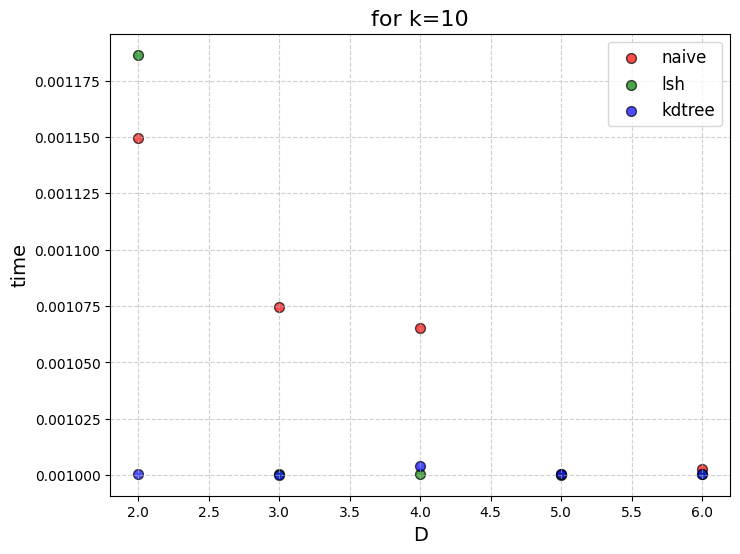

In [222]:
# mem :
k = 10
D = [2, 3, 4, 5, 6]
N = 100

naive_time = [0.0011494159698486328, 0.0010745525360107422,  0.0010653138160705566,0.0010007619857788086,0.0010025501251220703 ]
lsh_time = [0.0011864900588989258, 0.001000523567199707,0.0010006427764892578,  0.00100022554397583, 0.0010004043579101562]
kdtree_time = [ 0.0010003447532653809, 0.0010002851486206055, 0.001004040241241455,0.001000523567199707, 0.0010006427764892578]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(D, naive_time, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(D, lsh_time, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(D, kdtree_time, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=10", fontsize=16)
plt.xlabel("D", fontsize=14)
plt.ylabel("time", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

In [ ]:
# mem :
k = 10
D = [2, 3, 4, 5, 6]
N = 100

naive_time = [0.0010336041450500488, 0.0009999871253967285, 0.0009999871253967285, 0.0010012388229370117, 0.0010930895805358887]
lsh_time = [0.0009998679161071777, 0.0010584592819213867, 0.0010001063346862793, 0.0010045766830444336, 0.0009996891021728516]
kdtree_time = [ 0.0010004043579101562, 0.001002192497253418, 0.0010004639625549316, 0.0011283159255981445, 0.0010001063346862793]

plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(N, naive_time, c="red", s=50, alpha=0.7, edgecolors="k", label="naive")
plt.scatter(N, lsh_time, c="green", s=50, alpha=0.7, edgecolors="k", label="lsh")
plt.scatter(N, kdtree_time, c="blue", s=50, alpha=0.7, edgecolors="k", label="kdtree")

# Adding labels and title
plt.title("for k=10", fontsize=16)
plt.xlabel("N", fontsize=14)
plt.ylabel("time", fontsize=14)

# Customize the grid
plt.grid(True, linestyle="--", alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()